## 1 Regularized Linear Regression 
We will implement regularized linear regression to predict the amount of water flowing out of a dam 
using the change of water level in a reservoir

In [1]:
import scipy.io # to load .mat file
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

## 1.1 Visualizing the dataset 

In [2]:
data = scipy.io.loadmat('data/ex5data1.mat')
X, y = data['X'], data['y']
Xtest, ytest = data['Xtest'], data['ytest']
Xval, yval = data['Xval'], data['yval']

# add bias term
X = np.insert(X, 0, 1, axis=1) 
Xtest = np.insert(Xtest, 0, 1, axis=1)
Xval = np.insert(Xval, 0, 1, axis=1) 

print(X.shape)
print(Xtest.shape)
print(Xval.shape)

(12, 2)
(21, 2)
(21, 2)


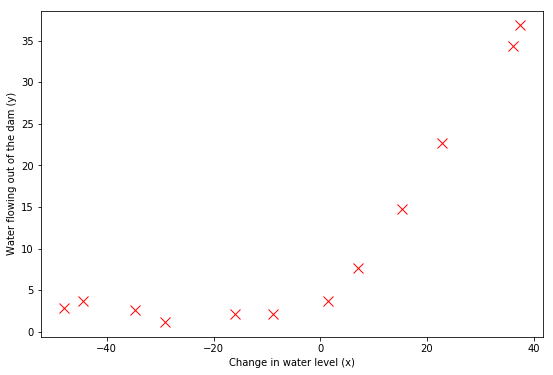

In [3]:
def plotData():
    plt.figure(figsize=(9,6))
    plt.plot(X[:,1:], y, 'rx', MarkerSize=10, LineWidth=1.5)
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')

plotData()

## 1.2 Regularized linear regression cost function 

In [4]:
def linearRegCostFunction(theta, X, y, _lambda=0.):
    """
    The input theta must be the form of 1D array for trainLinearReg below
    """
    theta = np.c_[theta] # convert 1D array to 2D array
    m = X.shape[0]
    h = X.dot(theta)
    J = np.mean((h-y)**2)/2 + _lambda*np.sum(theta[1:]**2)/(2*m)
    return J

In [5]:
theta = np.array([1,1])
J = linearRegCostFunction(theta, X, y, _lambda=1.)
print('Cost at theta = [1;1]: {:.9}\n(this value should be about 303.993192)'.format(J))

Cost at theta = [1;1]: 303.993192
(this value should be about 303.993192)


## 1.3 Regularized linear regression gradient 

In [6]:
def linearRegGradient(theta, X, y, _lambda=0.):
    """
    The input theta must be the form of 1D array for trainLinearReg below
    """    
    theta = np.c_[theta]
    m = X.shape[0]
    h = X.dot(theta)
    grad = X.T.dot(h-y)/m
    grad[1:] += _lambda*theta[1:]/m
    return grad.flatten()

In [7]:
theta = np.array([1,1])
grad = linearRegGradient(theta, X, y, _lambda=1.)
print('Cost at theta = [1;1]: \n{}\n(this value should be about [-15.303016; 598.250744])'.format(grad))

Cost at theta = [1;1]: 
[-15.30301567 598.25074417]
(this value should be about [-15.303016; 598.250744])


## 1.4 Fitting linear regression 

In [8]:
def trainLinearReg(X, y, _lambda=0.): 
    """
    Find the theta that optimize the linearRegCostFunction
    """
    theta_init = np.zeros(X.shape[1])
    res = optimize.fmin_cg(linearRegCostFunction, x0=theta_init, fprime=linearRegGradient, args=(X, y, _lambda),
                           maxiter=200, full_output=True, disp=False)
    return np.c_[res[0]] # res[0]:Parameter that minimizes function = theta
                          

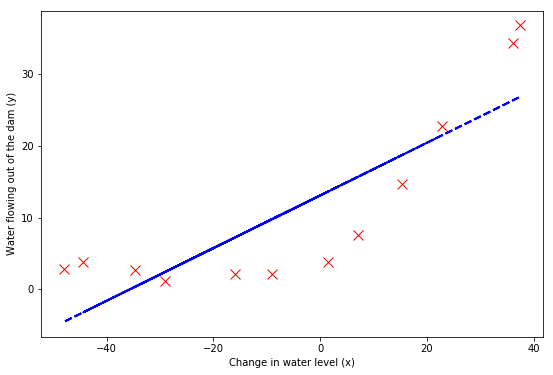

In [9]:
theta_final = trainLinearReg(X, y)
plotData()
y_predict = X.dot(theta_final)
plt.plot(X[:,1:], y_predict, 'b--', LineWidth=2)
plt.show()

# 2 Bias-variance 
We will plot training and cross validation errors on a learning curve to diagnose bias-variance problems.

## 2.1 Learning curves 

In [10]:
def learningCurve(X, y, Xval, yval, _lambda=0.):
    """
    Returns two vectors of the same length: error_train and error_val. 
    error_train[i] contains the training error for i examples (and similarly for error_val[i]).
    training error: evaluate on the first i training examples.
    cross-validation error: evaluate on the 'entire' cross validation set (Xval and yval).
    In particular, note that the training error does not include the regularization term, so set λ to 0.
    """
    m = X.shape[0]
    
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    
    for i in range(m):
        error_train[i] = np.mean((X[:i,:].dot(trainLinearReg(X[:i,:],y[:i],_lambda))-y[:i,:])**2)/2
        error_val[i] = np.mean((Xval.dot(trainLinearReg(X[:i,:],y[:i],_lambda))-yval)**2)/2

    return error_train, error_val

In [11]:
error_train, error_val = learningCurve(X, y, Xval, yval)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


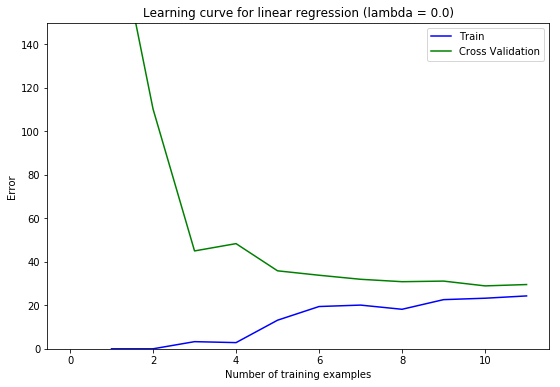

Both the train error and cross validation error are high when the number of training examples is increased.       
This reflects a underfitting(high bias) problem in the model.


In [12]:
def plotLearningCurve(_lambda=0.):
    plt.figure(figsize=(9,6))
    plt.plot(error_train, 'b-', label='Train')
    plt.plot(error_val, 'g-', label='Cross Validation')
    plt.legend(loc='best')
    plt.title('Learning curve for linear regression (lambda = {})'.format(_lambda))
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.ylim((0,13))
    plt.ylim((0,150))

plotLearningCurve()
plt.show()

print('Both the train error and cross validation error are high when the number of training examples is increased. \
      \nThis reflects a underfitting(high bias) problem in the model.')

# 3 Polynomial regression 
We will address underfitting by adding more features,
and then proceed to train polynomial regression using trainLinearReg

## 3.1 Learning Polynomial Regression 

In [13]:
def polyFeatures(X, p):
    """
    Takes a data matrix X shape: (m,1), and maps each example into its polynomial features .
    """
    X_poly = X.copy()
    for i in range(2,p+1):
        temp = np.c_[X**i]
        X_poly = np.append(X_poly, temp, axis=1)
    return X_poly

# Before learning the parameters θ for the polynomial regression, we need to use feature normalization.
def featureNormalize(X):
    """
    Returns a normalized version of X where the mean value of each feature is 0 and the standard deviation is 1. 
    This is often a good preprocessing step to do when working with learning algorithms.
    """
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X-mu)/sigma
    return X_norm, mu, sigma

In [14]:
# Map X onto Polynomial Features and Normalize
# d=8 plot doesn't match the homework pdf, due to differences between scipy.optimize.fmin_cg and the MATLAB version
# so here we ues d=6 (reference: https://github.com/kaleko/CourseraML/blob/master/ex5/ex5.ipynb)
p = 6  
X_poly = polyFeatures(X[:,1:], p)
X_poly, mu, sigma = featureNormalize(X_poly)
X_poly = np.insert(X_poly, 0, 1, axis=1)

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest[:,1:], p)
X_poly_test = (X_poly_test-mu)/sigma
X_poly_test = np.insert(X_poly_test, 0, 1, axis=1)

# Map X_poly_test and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval[:,1:], p)
X_poly_val = (X_poly_val-mu)/sigma
X_poly_val = np.insert(X_poly_val, 0, 1, axis=1)

In [15]:
_lambda = 0
theta_final = trainLinearReg(X_poly, y, _lambda)
theta_final

array([[ 11.21758964],
       [ 10.88679752],
       [ 12.86202775],
       [ 10.2849277 ],
       [ -4.20092115],
       [-11.41401177],
       [ -4.90366301]])

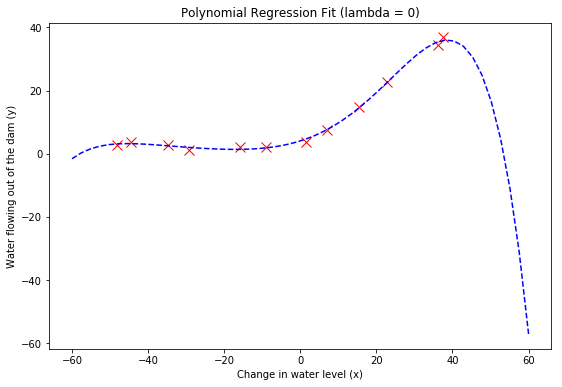

The polynomial fit is able to follow the datapoints very well - thus, obtaining a low training error.      
However, the polynomial fit is very complex and even drops off at the extremes. (see the right part)       
It indicates that the polynomial regression model is overfitting the training data and will not generalize well.


In [16]:
def plotFit(theta_final, mu, sigma, p):
    """
    plots the learned polynomial fit with power p and feature normalization (mu, sigma).
    """
    x = np.c_[np.linspace(-60,60)]
    x_poly = polyFeatures(x,p)
    x_poly = np.insert(x_poly, 0, 1, axis=1)
    x_poly[:,1:] = x_poly[:,1:] - mu
    x_poly[:,1:] = x_poly[:,1:] / sigma
    plotData()
    plt.plot(x, x_poly.dot(theta_final), 'b--')
    plt.title('Polynomial Regression Fit (lambda = {})'.format(_lambda))

plotFit(theta_final, mu, sigma, p)
plt.show()
print('The polynomial fit is able to follow the datapoints very well - thus, obtaining a low training error.\
      \nHowever, the polynomial fit is very complex and even drops off at the extremes. (see the right part) \
      \nIt indicates that the polynomial regression model is overfitting the training data and will not generalize well.')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


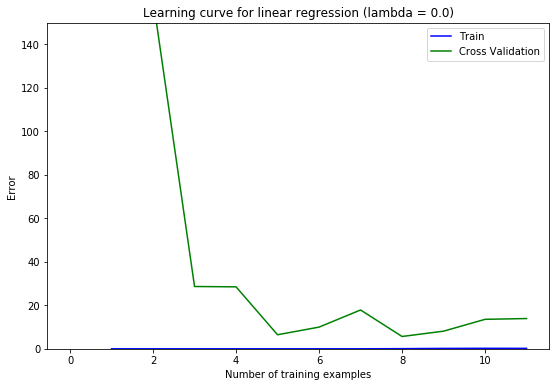

It shows that while the low training error is low, the cross validation error is high.        
There is a gap between the training and cross validation errors, indicating a high variance problem.


In [17]:
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval)
plotLearningCurve()
plt.show()
print('It shows that while the low training error is low, the cross validation error is high. \
       \nThere is a gap between the training and cross validation errors, indicating a high variance problem.')

## 3.2 Adjusting the regularization parameter 
One way to combat the overfitting (high-variance) problem is to add regularization to the model.

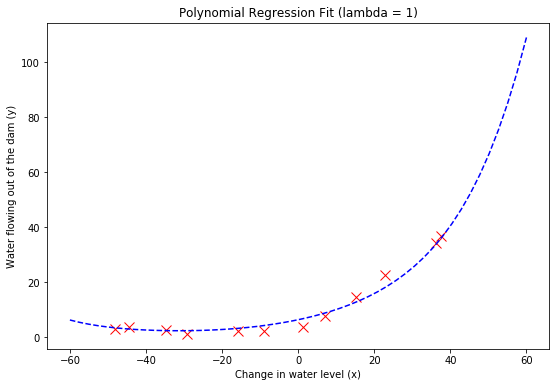

In [18]:
_lambda = 1
theta_final = trainLinearReg(X_poly, y, _lambda)
plotFit(theta_final, mu, sigma, p)
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


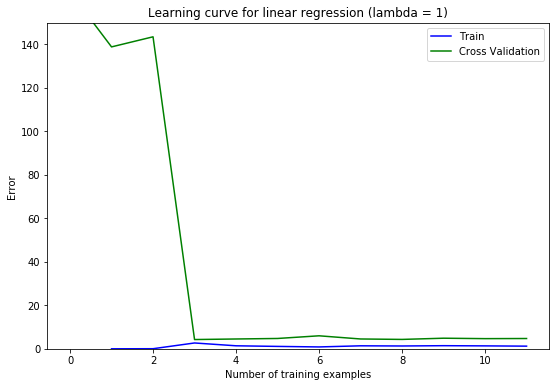

It shows that both the cross validation and training error converge to a relatively low value.        
This shows the λ = 1 regularized polynomial regression model does not have the high-bias or high-variance problems.       
In effect, it achieves a good trade-off between bias and variance.


In [19]:
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, _lambda)
plotLearningCurve(_lambda)
plt.show()
print('It shows that both the cross validation and training error converge to a relatively low value. \
       \nThis shows the λ = 1 regularized polynomial regression model does not have the high-bias or high-variance problems.\
       \nIn effect, it achieves a good trade-off between bias and variance.')

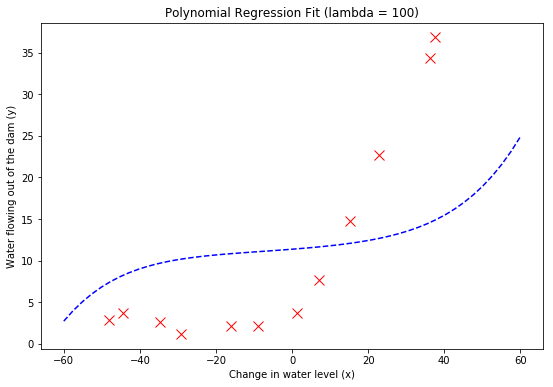

In this case, there is too much regularization and the model is unable to fit the training data.


In [20]:
_lambda = 100
theta_final = trainLinearReg(X_poly, y, _lambda)
plotFit(theta_final, mu, sigma, p)
plt.show()
print('In this case, there is too much regularization and the model is unable to fit the training data.')

## 3.3 Selecting λ using a cross validation set 

In [21]:
def validationCurve(X, y, Xval, yval):
    """
    returns the train and validation errors (in error_train, error_val) for different values of lambda. 
    """
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    m = len(lambda_vec)
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    for i,_lambda in enumerate(lambda_vec):
        error_train[i] = np.mean((X.dot(trainLinearReg(X,y,_lambda))-y)**2)/2
        error_val[i] = np.mean((Xval.dot(trainLinearReg(X,y,_lambda))-yval)**2)/2
    return lambda_vec, error_train, error_val

In [22]:
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

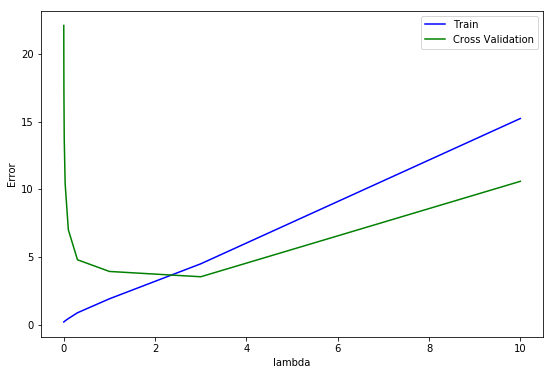

We can see that the best value of λ is around 3.       
Due to randomness in the training and validation splits of the dataset, the cross validation error can sometimes be  lower than the training error.


In [23]:
plt.figure(figsize=(9,6))
plt.plot(lambda_vec, error_train, 'b-', label='Train')
plt.plot(lambda_vec, error_val, 'g-', label='Cross Validation')
plt.xlabel('lambda')
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()
print('We can see that the best value of λ is around 3. \
      \nDue to randomness in the training and validation splits of the dataset, the cross validation error can sometimes be  lower than the training error.')

## 3.4 Optional (ungraded) exercise: Computing test set error 

In [24]:
_lambda = 3
theta_final = trainLinearReg(X_poly, y, _lambda)
test_error = np.mean((X_poly_test.dot(theta_final) - ytest)**2)/2
test_error

4.397642375827346